# Telegram posts / messages prediction using a logistic regression model

## Preparation

### Importing libraries

In [44]:
# Basic libraries for analysis
import pandas as pd
import numpy as np
import re
import pickle

# Text preparation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

# Building simple graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Model creating and operation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import eli5

# Visualising progress
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

C:\Users\samal\AppData\Local\Temp\ipykernel_26632\696415874.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

### Setting up functions

In [3]:
def lemmatize(doc:str):
    '''
    Function for lemmatizing strings

    Args:
    doc(str): a string to be lemmatized 

    Returns:
    tokens(str): a lemmatized string
    '''
    # Only keep the relevant symbols and words
    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    morph = MorphAnalyzer()
    stopwords_ru = stopwords.words("russian")
    
    # Conduct the actual procedure
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
            ' '.join(tokens)
    
    # Return only data with more then 2 words in it
    if len(tokens) > 2:
        return tokens
    return None

In [4]:
def prepare_text(data,
                 cleaned_text_column='cleaned_text'
                 ):
    '''
    Function for preparing the text for analysis
    
    Args:
    data(pd.DataFrame): a dataframe on which to operate
    cleaned_text_column(str): name of the column in which to put the processed text

    Returns:
    data(pd.DataFrame): the same dataframe but with added processed text column
    '''
    
    # Change the text into a lower register and replace "ё" with "е" (russian letters generally considered to be interchangable)
    data['text'] = data['text'].str.lower().replace("ё", "е")

    # Lemmatizing the text
    only_text_data = data['text'].astype(str)
    text_preps = only_text_data.progress_apply(lemmatize)

    # Add the result to a new dataframe:
    text_preps = text_preps.to_frame().reset_index(drop=True).fillna(value="-")

    # Connect the list of words into a full sentence
    for i in tqdm_notebook(range(len(text_preps))):
        stringy = ' '.join(text_preps.loc[i, 'text'])
        text_preps.loc[i, 'text'] = stringy

    # Adding the new processed text column
    data[cleaned_text_column] = text_preps['text'].values

    return data

In [40]:
def evaluate_model(y_test,
                   y_pred, 
                   probabilities):
    '''
    Function for evaluating the key metrics of the models
    
    Args:
    y_test(np.array): an array with y values from the test sample
    y_pred(np.array): an array with y values predicted by the model
    probabilities(np.array): an array of prediction probabilities for each item in the sample
    '''

    # Printing the confusion matrix. Using raw numbers (not percentages)
    cnf_matrix = confusion_matrix(y_test,y_pred)
    group_names = ['TN','FP','FN','TP'] 
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    # Displaying
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Greens')
    plt.title('Confusion matrix for the current model')
    plt.show()

    # Displaying the model metrics
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

### Importing data

In [5]:
# Loading data - a sample for analysis
posts_data = pd.read_excel('Sample.xlsx')
posts_data.head(5)

,number,text,mark
0,1,"Здравствуйте, подскажите, пожалуйста, ЛОР (ото...",1
1,2,Всем здравствуйте ищу помещение в Стамбуле гот...,1
2,3,Добрый день. \nУ меня мануфактура по производс...,1
3,4,"Здравствуйте. Требуется сварщик, если у кого е...",1
4,5,Всем привет. Есть кто занимается запчастями дл...,1


In [6]:
# Preparing text for analysis
prepare_text(posts_data)
posts_data.head(5)

  0%|          | 0/1457 [00:00<?, ?it/s]

C:\Users\samal\AppData\Local\Temp\ipykernel_26632\1420675088.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(text_preps))):


  0%|          | 0/1457 [00:00<?, ?it/s]

,number,text,mark,cleaned_text
0,1,"здравствуйте, подскажите, пожалуйста, лор (ото...",1,здравствуйте подсказать пожалуйста лор отолари...
1,2,всем здравствуйте ищу помещение в стамбуле гот...,1,весь здравствуйте искать помещение стамбул гот...
2,3,добрый день. \nу меня мануфактура по производс...,1,добрый день мануфактура производство интерьерн...
3,4,"здравствуйте. требуется сварщик, если у кого е...",1,здравствуйте требоваться сварщик кто знакомый ...
4,5,всем привет. есть кто занимается запчастями дл...,1,весь привет заниматься запчасть рено


## Model building stage

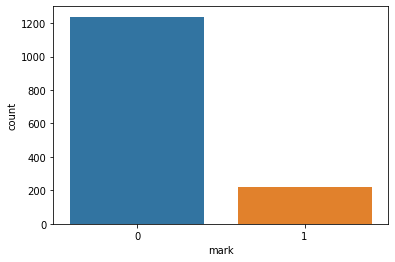

In [10]:
# Evaluating the sample sizes:
ax = sns.countplot(x="mark", data=posts_data)

The sample is unbalanced - that needs to be accounted for while choosing a model

In [21]:
# Initialize the text transformer (to convert text into a matrix that can be interpreted by the model).
text_transformer = TfidfVectorizer(stop_words=None, # None are needed since they have already been removed prior to that stage
                                   ngram_range=(1,2), # (1,3) is also a viable option
                                   lowercase=True, #Technically not needed, as pre-processing already took care of it
                                   max_features=150000) # Is not needed at current stage, but with the expansion of sample - will be

In [22]:
# Splitting the data into train and test samples.
X_train, X_test, y_train, y_test = train_test_split(posts_data['cleaned_text'].values,
                                                     posts_data['mark'].values,
                                                     test_size=0.2,
                                                     random_state=15, # To ensure that model can be replicated
                                                     stratify=posts_data['mark'].values)

In [23]:
# Creating a copy of text data (since the current DataFrame will be transformed)
X_test_text = X_test.copy()

In [24]:
# Transforming the text into matrix
X_train = text_transformer.fit_transform(X_train)
X_test = text_transformer.transform(X_test)

# Checking the total size of the resulting matrix
print(f'Size of the train sample = {X_train.shape[0]}')
print(f'Size of the test sample = {X_test.shape[0]}')
print(f'Number of columns (words in vocabulary) = {X_train.shape[1]}')

Size of the train sample = 1165
Size of the test sample = 292
Number of columns (words in vocabulary) = 16284


In [94]:
# Building a standard model
logit = LogisticRegression(C=5e1, 
                           solver='liblinear', 
                           multi_class='auto', 
                           random_state=22, 
                           n_jobs=4)

# Building a tool for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


D:\Python\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
D:\Python\Python 3.10\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

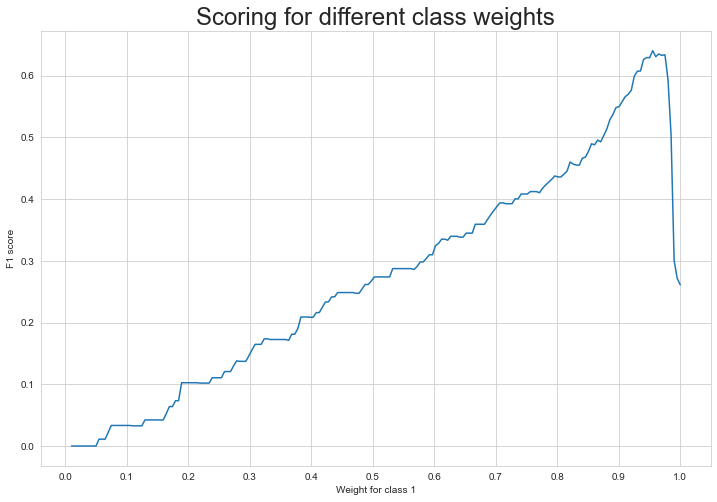

In [95]:
# Analyzing optimal weights for our model
lr = LogisticRegression(solver='liblinear')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator=logit, 
                          param_grid=param_grid,
                          cv=skf, 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [96]:
# Fitting the model
logit.fit(X_train, y_train)

# Displaying the resulting weights
eli5.show_weights(estimator=logit, 
                  feature_names= list(text_transformer.get_feature_names()),
                 top=(50, 5))

D:\Python\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
D:\Python\Python 3.10\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+9.313,подсказать
+8.321,контакт
+7.916,стамбул
+6.169,здравствуйте
+5.939,нужный
+5.817,добрый
+5.629,знать
+5.524,оптом
+5.475,найти
+4.824,пожалуйста


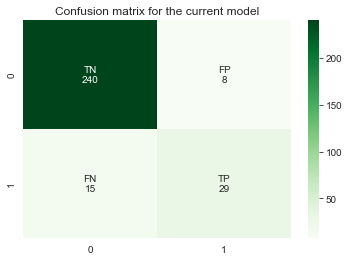

Accuracy: 0.92
Precision: 0.78
Recall: 0.66
F1: 0.72
ROC_AUC: 0.95


In [97]:
# Evaluating the model:
evaluate_model(y_test=y_test, 
               y_pred=y_pred, 
               probabilities=probabilities)

The results are not bad, but for the task at hand **recall is the more important metric** - it is better to get more False Positives, but less False Negatives.

Adjusting the model accordingly:

In [100]:
# Using custom predict to operate with prediction probabilities, rather then direct predictions. Lowering threshold to 0.2:
def custom_predict(X, threshold):
    probs = logit.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)
        
y_pred_new = custom_predict(X=X_test, threshold=0.1)

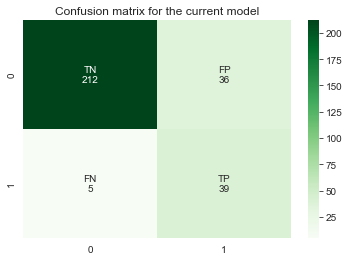

Accuracy: 0.86
Precision: 0.52
Recall: 0.89
F1: 0.66
ROC_AUC: 0.95


In [101]:
# Evaluating the new model:
evaluate_model(y_test=y_test, 
               y_pred=y_pred_new, 
               probabilities=probabilities)

**The recall has increased substantially**, although precision has failed just as significantly and F1 metric has reduced slightly. Still, this option is preferable for the task at hand.

## Saving the model for later use

In [ ]:
# Saving the vocabulary for vectorizer:
pickle.dump(text_transformer.vocabulary_, open("feature.pkl", "wb"))

# Saving the vectorizer:
pickle.dump(text_transformer, open('vectorizer.pkl', 'wb'))

# Saving the Logit model:
pickle.dump(logit, open("logit_model.pkl", "wb"))

The **model is currently operating properly** within specified parameters. However, there are certain issues that could be adressed later on:
1. Relatively small sample size limits the capabilities of the model. Future expansion and subsequent re-training of the model will increase its effectiveness in operation significantly.
2. The model does not account for size of messages (due to the 'bag of words' design) - although that is so by choice (not to miss very short, but relevant messages), the model can demonstrate an overwhelming level of certainty in one- or two- words messages.
3. The model currently utilizes a relatively basic approach - no ensembles and a simple logistic regression. With the addition of more data it would be possible to expand it and utilize more complex techniques in order to increase perfomance. That is the prime direction for further development.

**Following sources** have been of great assistance:

1. https://www.kaggle.com/code/kashnitsky/logistic-regression-tf-idf-baseline
2. https://www.kaggle.com/code/neerajmohan/nlp-text-classification-using-tf-idf-features
3. https://github.com/kavgan/nlp-in-practice/blob/master/text-classification/notebooks/Text%20Classification%20with%20Logistic%20Regression.ipynb